In [183]:
import numpy as np
import matplotlib.pyplot as plt

# Check NumPy version compatibility
if int(np.__version__.split('.')[0]) >= 2:
    print(f"Warning: Detected NumPy {np.__version__}, imgaug is incompatible with NumPy 2.0+")
    print("Solution: Downgrade NumPy to version 1.x")
    print("Run command: pip install 'numpy<2.0'")
    print("Or: pip install numpy==1.26.4")

import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
try:
    from imgaug import augmenters as iaa
except (ImportError, AttributeError) as e:
    if "sctypes" in str(e) or "np.sctypes" in str(e):
        print("\nError: imgaug is incompatible with NumPy 2.0+")
        print("Solution: Downgrade NumPy")
        print("Run command: pip install 'numpy<2.0'")
        print("Or: pip install numpy==1.26.4")
    else:
        print("Warning: imgaug is not installed. Please run: pip install imgaug")
    raise

import random

Found 1964 .bmp files (train: 1464, validate: 500)
Found 500 test .bmp files (test directory exists)
Data shape: x_data=(1964, 356, 328, 1), y_data=(1964, 4)
Image data type: uint8, pixel value range: [0, 255]

Test set loaded: (500, 356, 328, 1), (500, 4)

Training set: (1464, 356, 328, 1), (1464, 4)
Validation set: (500, 356, 328, 1), (500, 4)
Test set: (500, 356, 328, 1), (500, 4)

✓ Training and validation sets are separated to avoid data leakage

Data Count Summary
Training set:
  Number of images: 1464
  Number of labels: 1464
  Image shape: (356, 328, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Validation set:
  Number of images: 500
  Number of labels: 500
  Image shape: (356, 328, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Total dataset:
  Total images: 1964
  Total labels: 1964


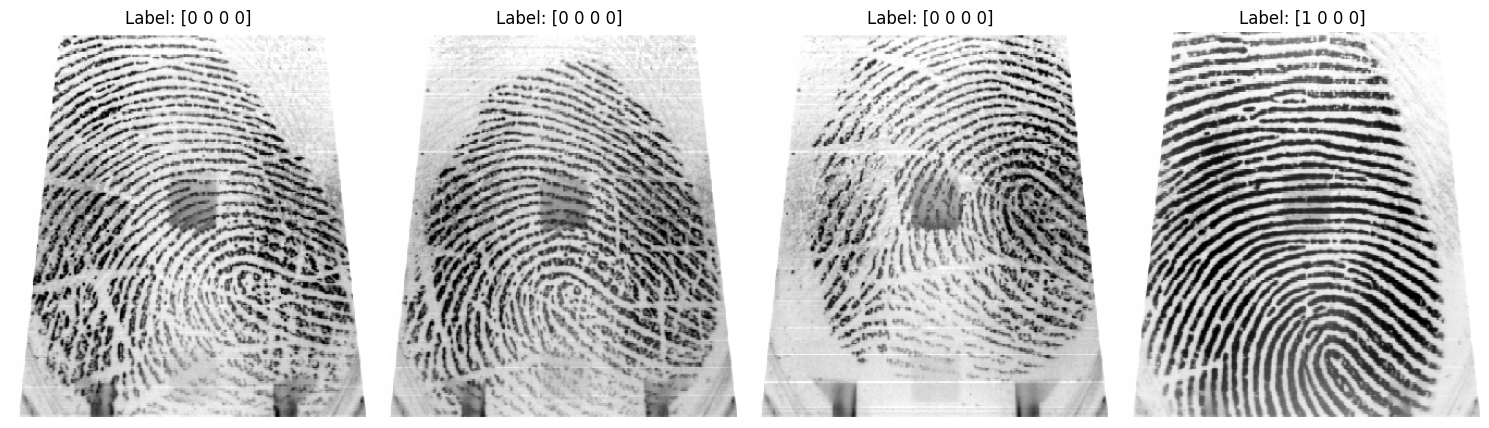

In [184]:
# ============================================
# Load Project-Data Dataset
# ============================================
import os
import glob

def load_project_data(data_dir='Project-Data', img_size=(356, 328)):
    """
    Load Project-Data dataset from .bmp files
    Parameters:
        data_dir: Dataset directory path
        img_size: Target image size (height, width) - already processed to this size
    Returns:
        x_data: Image data array (N, 90, 90, 1) - uint8, [0, 255]
        y_data: Label data array (N, 4) - [subject_id(3), gender(1), left_right(1), finger(1)]
        file_paths: List of file paths corresponding to each image
    """
    import cv2
    
    # Define data directories
    train_dir = os.path.join(data_dir, 'train')
    validate_dir = os.path.join(data_dir, 'validate')
    test_dir = os.path.join(data_dir, 'test')
    
    # Collect all .bmp files
    train_files = sorted(glob.glob(os.path.join(train_dir, '*.bmp')))
    validate_files = sorted(glob.glob(os.path.join(validate_dir, '*.bmp')))
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp'))) if os.path.exists(test_dir) else []
    
    all_files = train_files + validate_files
    print(f"Found {len(all_files)} .bmp files (train: {len(train_files)}, validate: {len(validate_files)})")
    if test_files:
        print(f"Found {len(test_files)} test .bmp files (test directory exists)")
    
    # Store images, labels, and file paths
    images = []
    labels = []
    file_paths = []
    
    for file_path in all_files:
        try:
            # Read preprocessed image from .bmp file (uint8, [0, 255])
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to read image {file_path}")
                continue
            
            # Verify image shape
            # if img.shape != img_size:
            #     print(f"Warning: Image {file_path} has shape {img.shape}, expected {img_size}")
            #     # Resize if necessary (shouldn't happen if preprocessing was correct)
            #     img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            
            # Add channel dimension (90, 90) -> (90, 90, 1)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
            file_paths.append(file_path)  # Save file path
            
            # Parse label from filename
            # Filename format: ID_R0_number.bmp or similar
            filename = os.path.basename(file_path)
            filename_no_ext = filename.replace('.bmp', '')
            parts = filename_no_ext.split('_')
            
            if len(parts) >= 1:
                # Extract subject_id (from first part of filename)
                subject_id = int(parts[0])
                # For other information, use default values if not explicitly identified
                # Can be adjusted based on actual filename format
                gender = 0  # Default value, can be adjusted based on actual data
                left_right = 0  # Default value, can be adjusted based on actual data
                finger = 0  # Default value, can be adjusted based on actual data
                
                # If filename contains more information, can parse here
                # For example: if format is ID_Gender_LR_Finger_number
                if len(parts) >= 2:
                    # Can try to extract more information from filename
                    pass
                
                label = np.array([subject_id, gender, left_right, finger], dtype=np.int32)
                labels.append(label)
            else:
                print(f"Warning: Unable to parse filename {filename}")
        except Exception as e:
            print(f"Warning: Unable to load {file_path}: {str(e)}")
            continue
    
    # Convert to numpy arrays
    # Images are uint8 with values in [0, 255] from .bmp files
    x_data = np.array(images, dtype=np.uint8)
    y_data = np.array(labels, dtype=np.int32)
    
    print(f"Data shape: x_data={x_data.shape}, y_data={y_data.shape}")
    print(f"Image data type: {x_data.dtype}, pixel value range: [{x_data.min()}, {x_data.max()}]")
    return x_data, y_data, file_paths

# Load Project-Data dataset
# Note: Keep train and validate directories separated to avoid data leakage
x_data, label_data, file_paths = load_project_data('Project-Data', img_size=(356, 328))

# Method 1: Use train_test_split for random splitting (will mix together)
# x_train, x_val, label_train, label_val = train_test_split(
#     x_data, label_data, test_size=0.2, random_state=42
# )

# Method 2: Separate according to original directory structure (recommended, avoids data leakage)
# From the load_project_data function we know:
# - train_files has 1464 files
# - validate_files has 500 files
# According to loading order, first 1464 are training set, last 500 are validation set
num_train = 1464  # Can be seen from output
x_train = x_data[:num_train]
label_train = label_data[:num_train]
train_file_paths = file_paths[:num_train]  # Save training file paths
x_val = x_data[num_train:]
label_val = label_data[num_train:]
val_file_paths = file_paths[num_train:]  # Save validation file paths

# Load test set if it exists
x_test = None
label_test = None
test_file_paths = None
test_dir = os.path.join('Project-Data', 'test')
if os.path.exists(test_dir):
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp')))
    
    if test_files:
        test_images = []
        test_labels = []
        test_file_paths = []
        
        for file_path in test_files:
            try:
                # Read preprocessed image from .bmp file (uint8, [0, 255])
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Unable to read test image {file_path}")
                    continue
                
                # # Verify image shape
                # if img.shape != (90, 90):
                #     print(f"Warning: Test image {file_path} has shape {img.shape}, expected (90, 90)")
                #     # Resize if necessary (shouldn't happen if preprocessing was correct)
                #     img = cv2.resize(img, (90, 90), interpolation=cv2.INTER_AREA)
                
                # Add channel dimension (90, 90) -> (90, 90, 1)
                img = np.expand_dims(img, axis=-1)
                test_images.append(img)
                test_file_paths.append(file_path)
                
                filename = os.path.basename(file_path)
                filename_no_ext = filename.replace('.bmp', '')
                parts = filename_no_ext.split('_')
                if len(parts) >= 1:
                    subject_id = int(parts[0])
                    label = np.array([subject_id, 0, 0, 0], dtype=np.int32)
                    test_labels.append(label)
            except Exception as e:
                print(f"Warning: Unable to load test file {file_path}: {str(e)}")
                continue
        
        x_test = np.array(test_images, dtype=np.uint8)
        label_test = np.array(test_labels, dtype=np.int32)
        print(f"\nTest set loaded: {x_test.shape}, {label_test.shape}")

print(f"\nTraining set: {x_train.shape}, {label_train.shape}")
print(f"Validation set: {x_val.shape}, {label_val.shape}")
if x_test is not None:
    print(f"Test set: {x_test.shape}, {label_test.shape}")
print(f"\n✓ Training and validation sets are separated to avoid data leakage")

# Print detailed data counts
print("\n" + "="*60)
print("Data Count Summary")
print("="*60)
print(f"Training set:")
print(f"  Number of images: {len(x_train)}")
print(f"  Number of labels: {len(label_train)}")
print(f"  Image shape: {x_train.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_train.shape[1:]} (4 values per label)")
print(f"\nValidation set:")
print(f"  Number of images: {len(x_val)}")
print(f"  Number of labels: {len(label_val)}")
print(f"  Image shape: {x_val.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_val.shape[1:]} (4 values per label)")
print(f"\nTotal dataset:")
print(f"  Total images: {len(x_data)}")
print(f"  Total labels: {len(label_data)}")
print("="*60)

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(min(4, len(x_train))):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Label: {label_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# diffrent techique appplied

In [185]:

print("Data information (already loaded and split in Cell 1):")
print(f"Total data: x_data={x_data.shape}, label_data={label_data.shape}")
print(f"Training set: x_train={x_train.shape}, label_train={label_train.shape}")
print(f"Validation set: x_val={x_val.shape}, label_val={label_val.shape}")

Data information (already loaded and split in Cell 1):
Total data: x_data=(1964, 356, 328, 1), label_data=(1964, 4)
Training set: x_train=(1464, 356, 328, 1), label_train=(1464, 4)
Validation set: x_val=(500, 356, 328, 1), label_val=(500, 4)


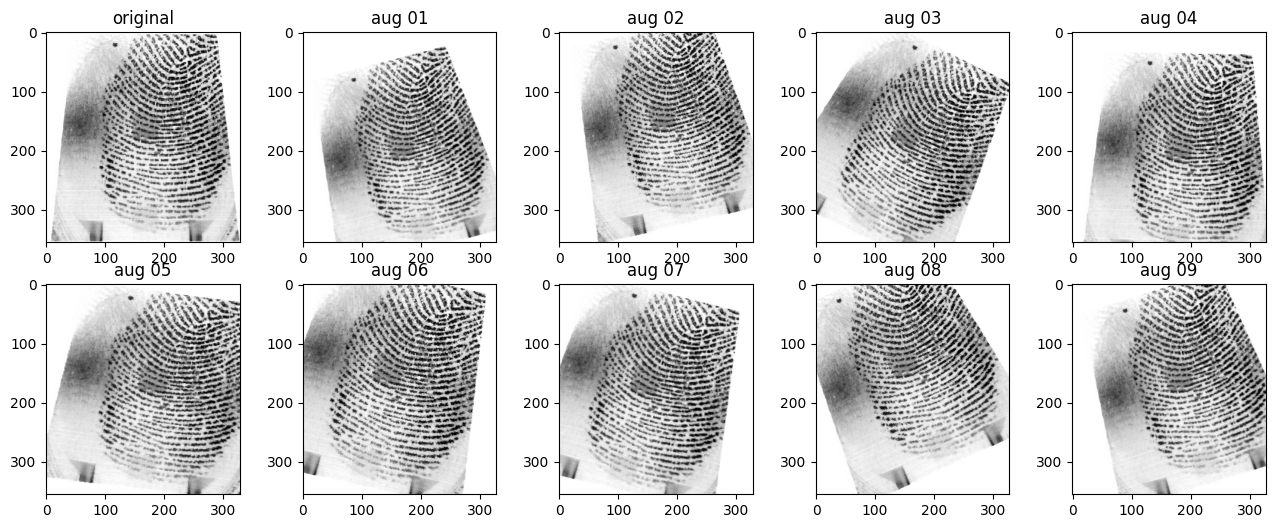

In [186]:
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
augs = [x_data[sample_idx]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
plt.imshow(x_data[sample_idx].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# enhacement

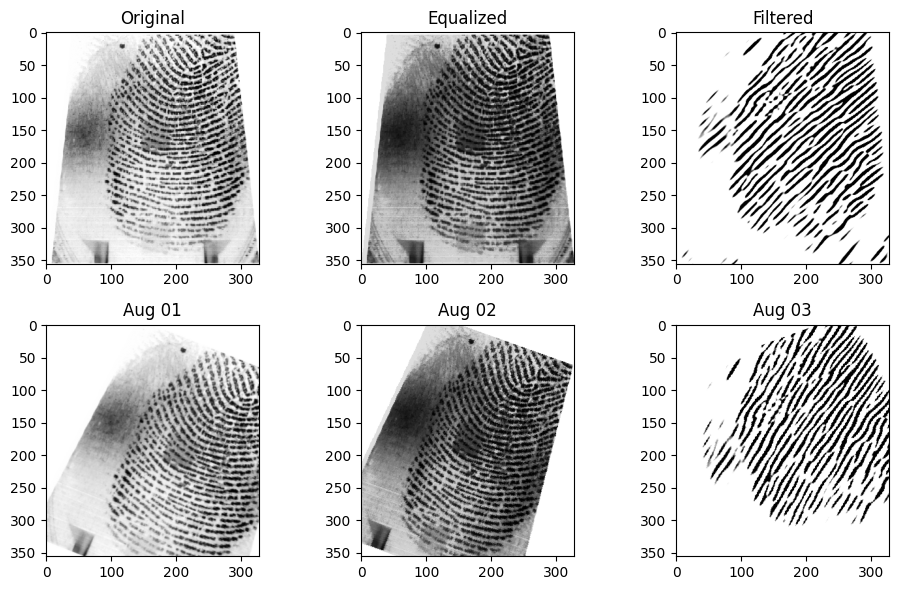

In [187]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Load the original image (use index that actually exists in dataset)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
original_image = x_data[sample_idx]

# Apply histogram equalization to enhance contrast
equalized_image = cv2.equalizeHist(original_image.squeeze())

# Define the parameters for Gabor filtering
ksize = (31, 31)  # Kernel size
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
psi = 0.0  # Phase offset

# Create the Gabor filter
gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

# Apply Gabor filtering
filtered_image = cv2.filter2D(original_image.squeeze(), cv2.CV_8UC3, gabor_kernel)

# Create augmentation sequence
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Blur images with a sigma of 0 to 0.5
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # Scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate by -10 to +10 percent (per axis)
        rotate=(-30, 30),  # Rotate by -30 to +30 degrees
        order=[0, 1],  # Use nearest neighbor or bilinear interpolation (fast)
        cval=255  # If mode is constant, use a cval between 0 and 255
    )
], random_order=True)

# Apply augmentation to the images
enhanced_augs = seq.augment_images([original_image, equalized_image, filtered_image])

# Plot the original and augmented images
plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Original')
plt.imshow(original_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 2)
plt.title('Equalized')
plt.imshow(equalized_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 3)
plt.title('Filtered')
plt.imshow(filtered_image.squeeze(), cmap='gray')

for i, aug in enumerate(enhanced_augs):
    plt.subplot(2, 5, i+6)
    plt.title('Aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()


In [188]:
# ============================================
# Create label_real_dict and x_real for Project-Data
# ============================================
# Important: x_real should only contain training set images to avoid data leakage
# This way, during training and validation, the model won't "see" validation set reference images
label_real_dict = {}
x_real_list = []
y_real_list = []
x_real_file_paths = []  # Store file paths for x_real images

# Use dictionary to track image index for each unique label
# key: label string, value: index in x_real
seen_labels = {}

# Create reference image set using only training set (avoid data leakage)
print("Creating reference image set (using only training set to avoid data leakage)...")
for i, label in enumerate(label_train):
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    
    if key not in seen_labels:
        # Save first image for each unique label as reference
        seen_labels[key] = len(x_real_list)
        label_real_dict[key] = len(x_real_list)
        x_real_list.append(x_train[i])
        y_real_list.append(label)
        x_real_file_paths.append(train_file_paths[i])  # Save corresponding file path
    else:
        # If already exists, update dictionary to point to existing index
        label_real_dict[key] = seen_labels[key]

# Convert to numpy arrays
x_real = np.array(x_real_list, dtype=np.uint8)
y_real = np.array(y_real_list, dtype=np.int32)

print(f"Reference image set (x_real): {x_real.shape}")
print(f"Reference label set (y_real): {y_real.shape}")
print(f"Number of unique labels: {len(seen_labels)}")
print(f"label_real_dict size: {len(label_real_dict)}")

# Verify: Check if all labels in training set are in dictionary
def check_labels_in_dict(labels, label_dict, name):
    """Check if all labels are in dictionary"""
    keys = set()
    for label in labels:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        keys.add(key)
    
    missing_keys = keys - set(label_dict.keys())
    if missing_keys:
        print(f"Warning: {name} has {len(missing_keys)} labels not in label_real_dict")
        print(f"Example missing keys: {list(missing_keys)[:5]}")
        return False, missing_keys
    else:
        print(f"✓ All labels in {name} are in label_real_dict")
        return True, set()

# Check training set (must all be in dictionary)
train_ok, train_missing = check_labels_in_dict(label_train, label_real_dict, "Training set")

# If there are missing labels, add them from training set
if train_missing:
    print(f"\nFound {len(train_missing)} missing labels, adding from training set...")
    for label in label_train:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        if key in train_missing and key not in label_real_dict:
            idx = np.where((label_train == label).all(axis=1))[0]
            if len(idx) > 0:
                label_real_dict[key] = len(x_real_list)
                x_real_list.append(x_train[idx[0]])
                y_real_list.append(label)
                x_real_file_paths.append(train_file_paths[idx[0]])  # Save file path
                train_missing.remove(key)
    
    # Update x_real and y_real
    x_real = np.array(x_real_list, dtype=np.uint8)
    y_real = np.array(y_real_list, dtype=np.int32)
    
    # Update file paths if needed (should already be updated in the loop above)
    print(f"Added missing labels, updated x_real shape: {x_real.shape}")
    print(f"Updated label_real_dict size: {len(label_real_dict)}")
    
    # Verify training set again
    train_ok, _ = check_labels_in_dict(label_train, label_real_dict, "Training set")

# Check validation set (validation set may have some new labels not in training set, this is normal)
val_keys = set()
for label in label_val:
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    val_keys.add(key)

val_missing = val_keys - set(label_real_dict.keys())
if val_missing:
    print(f"\nNote: Validation set has {len(val_missing)} labels not in training set")
    print(f"These will be handled using rejection mechanism (threshold-based) during inference")
    print(f"Example unknown labels: {list(val_missing)[:5]}")
else:
    print(f"\n✓ All labels in validation set are in training set (can evaluate completely)")

print("\n" + "="*60)
print("Training Strategy: Only Known Identities")
print("="*60)
print("✓ Model will only train on known identities (no UNKNOWN class)")
print("✓ Unknown fingerprints will be detected using rejection mechanism")
print("  (if similarity with all known identities < threshold, classify as UNKNOWN)")
print("="*60)

Creating reference image set (using only training set to avoid data leakage)...
Reference image set (x_real): (488, 356, 328, 1)
Reference label set (y_real): (488, 4)
Number of unique labels: 488
label_real_dict size: 488
✓ All labels in Training set are in label_real_dict

Note: Validation set has 12 labels not in training set
These will be handled using rejection mechanism (threshold-based) during inference
Example unknown labels: ['400000', '280000', '040000', '120000', '440000']

Training Strategy: Only Known Identities
✓ Model will only train on known identities (no UNKNOWN class)
✓ Unknown fingerprints will be detected using rejection mechanism
  (if similarity with all known identities < threshold, classify as UNKNOWN)


In [189]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)  # Newer Keras versions require calling super().__init__()
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Only train on known identities (no UNKNOWN class)
        # Unknown fingerprints will be handled during inference using threshold-based rejection
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 356, 328, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Data augmentation (applied on-the-fly during training)
        # Note: This is "online augmentation" - images are augmented differently each time
        # The dataset size remains the same (1464), but each epoch sees different variations
        # This effectively increases data diversity without expanding the dataset
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        # Only train on known identities - skip unknown fingerprints during training
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            # Only use known fingerprints for training
            # Skip unknown fingerprints (not in label_real_dict) - they will be handled during inference
            if match_key not in self.label_real_dict:
                # For unknown fingerprints, use a random known fingerprint as negative sample
                # This helps model learn to distinguish known from unknown
                unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.  # Negative sample: this is not a match
            else:
                # Known fingerprint: generate positive or negative sample
                if random.random() > 0.5:
                    # put matched image (positive sample: same fingerprint)
                    x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                    y_batch[i] = 1.
                else:
                    # put unmatched image (negative sample: different fingerprint)
                    while True:
                        unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                        if unmatch_key != match_key:
                            break
                    x2_batch[i] = self.x_real[unmatch_idx]
                    y_batch[i] = 0.

        # Ensure return format is tuple and data types are correct
        x1_batch = (x1_batch.astype(np.float32) / 255.)
        x2_batch = (x2_batch.astype(np.float32) / 255.)
        y_batch = y_batch.astype(np.float32)
        return (x1_batch, x2_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [190]:
# Create data generators
# Only train on known identities - unknown fingerprints will be handled during inference
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

print("="*60)
print("Data Generator Configuration (Threshold-based Rejection)")
print("="*60)
print("Training strategy:")
print("  - Known fingerprints: Compare with matching/non-matching known fingerprints")
print("  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)")
print("  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN")
print("="*60)

Data Generator Configuration (Threshold-based Rejection)
Training strategy:
  - Known fingerprints: Compare with matching/non-matching known fingerprints
  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)
  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN


In [191]:

x1 = layers.Input(shape=(356, 328, 1))
x2 = layers.Input(shape=(356, 328, 1))

# share weights both inputs
inputs = layers.Input(shape=(356, 328, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 356, 328,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_34      │ (None, 356, 328,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_22       │ (None, 89, 82,    │      9,568 │ input_layer_33[0… │
│ (Functional)        │ 32)               │            │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_11         │ (None, 89, 82,    │          0 │ functional_22[0]… │
│ (Subtract)          │ 32)               │            │ functional_22[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 89, 82,    │      9,248 │ subtract_11[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_36    │ (None, 44, 41,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 57728)     │          0 │ max_pooling2d_36… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │  3,694,656 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         65 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,713,537 (14.17 MB)

 Trainable params: 3,713,537 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

Finding Optimal Threshold using Validation Set
Known fingerprints in validation set: 488
Unknown fingerprints in validation set: 12

Calculating similarities for known fingerprints (genuine matches)...
Calculating similarities for unknown fingerprints...

Known fingerprints - Similarity statistics:
  Mean: 0.5040
  Std: 0.0095
  Min: 0.4790
  Max: 0.5303

Unknown fingerprints - Max similarity with known identities:
  Mean: 0.5314
  Std: 0.0080
  Min: 0.5199
  Max: 0.5497

Finding optimal threshold (maximize TPR*0.5 + TNR*0.5)...

Optimal threshold: 0.0000
TPR (True Positive Rate): 1.0000
TNR (True Negative Rate): 0.0000
Score: 0.5000

✓ Optimal threshold found: 0.0000
This threshold will be used for unknown fingerprint detection.
Testing Unknown Fingerprint (Stranger) - Threshold-based Rejection
Test image index: 40
Test label: [40  0  0  0]
Test key: 040000
File path: Project-Data/validate/040_R0_3.bmp
Total unknown fingerprints in validation set: 12
Threshold: 0.0000

Top 10 matches 

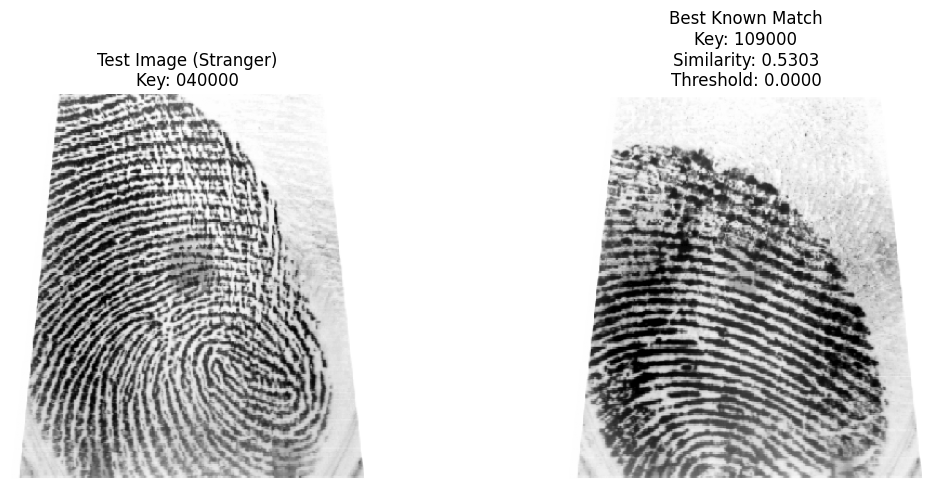

NameError: name 'similarity_unknown' is not defined

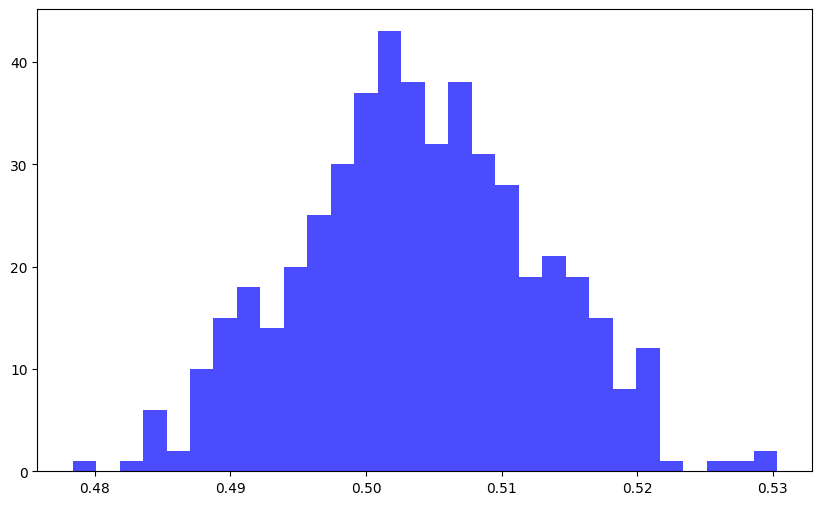

In [192]:
# ============================================
# Find Optimal Threshold using Validation Set
# ============================================
# Method 1: Use validation set to find optimal threshold
# Compare distance distributions of known vs unknown identities

def find_optimal_threshold(model, x_val, label_val, x_real, label_real_dict, 
                           method='tpr_tnr_weighted', weight_tpr=0.5, weight_tnr=0.5):
    """
    Find optimal threshold using validation set
    
    Parameters:
        model: Trained Siamese model
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        method: 'tpr_tnr_weighted' or 'roc_auc' or 'eer'
        weight_tpr: Weight for TPR (True Positive Rate) - for known fingerprints
        weight_tnr: Weight for TNR (True Negative Rate) - for unknown fingerprints
    
    Returns:
        optimal_threshold: Optimal threshold value
        metrics: Dictionary with performance metrics
    """
    from sklearn.metrics import roc_curve, auc
    
    print("="*70)
    print("Finding Optimal Threshold using Validation Set")
    print("="*70)
    
    # Get known and unknown samples from validation set
    val_keys = []
    known_indices = []
    unknown_indices = []
    
    for i, label in enumerate(label_val):
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
        if key in label_real_dict:
            known_indices.append(i)
        else:
            unknown_indices.append(i)
    
    print(f"Known fingerprints in validation set: {len(known_indices)}")
    print(f"Unknown fingerprints in validation set: {len(unknown_indices)}")
    
    # Calculate similarities for known fingerprints (genuine matches)
    print("\nCalculating similarities for known fingerprints (genuine matches)...")
    known_similarities = []
    for idx in known_indices:
        test_img = x_val[idx]
        test_key = val_keys[idx]
        
        # Find matching reference image
        ref_idx = label_real_dict[test_key]
        ref_img = x_real[ref_idx]
        
        # Calculate similarity
        test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
        ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
        similarity = model.predict([test_batch, ref_batch], verbose=0)[0][0]
        known_similarities.append(similarity)
    
    # Calculate similarities for unknown fingerprints (with all known identities)
    print("Calculating similarities for unknown fingerprints...")
    unknown_min_similarities = []
    for idx in unknown_indices:
        test_img = x_val[idx]
        test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
        
        # Calculate similarity with all known identities, take maximum
        max_similarity = 0.0
        for ref_idx in label_real_dict.values():
            ref_img = x_real[ref_idx]
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            similarity = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            max_similarity = max(max_similarity, similarity)
        unknown_min_similarities.append(max_similarity)
    
    known_similarities = np.array(known_similarities)
    unknown_min_similarities = np.array(unknown_min_similarities)
    
    print(f"\nKnown fingerprints - Similarity statistics:")
    print(f"  Mean: {np.mean(known_similarities):.4f}")
    print(f"  Std: {np.std(known_similarities):.4f}")
    print(f"  Min: {np.min(known_similarities):.4f}")
    print(f"  Max: {np.max(known_similarities):.4f}")
    
    print(f"\nUnknown fingerprints - Max similarity with known identities:")
    print(f"  Mean: {np.mean(unknown_min_similarities):.4f}")
    print(f"  Std: {np.std(unknown_min_similarities):.4f}")
    print(f"  Min: {np.min(unknown_min_similarities):.4f}")
    print(f"  Max: {np.max(unknown_min_similarities):.4f}")
    
    # Find optimal threshold
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_threshold = 0.5
    best_score = -1
    
    if method == 'tpr_tnr_weighted':
        # Maximize weighted sum of TPR and TNR
        print(f"\nFinding optimal threshold (maximize TPR*{weight_tpr} + TNR*{weight_tnr})...")
        for threshold in thresholds:
            # TPR: True Positive Rate (correctly identify known fingerprints)
            tpr = np.mean(known_similarities >= threshold)
            
            # TNR: True Negative Rate (correctly reject unknown fingerprints)
            tnr = np.mean(unknown_min_similarities < threshold)
            
            score = weight_tpr * tpr + weight_tnr * tnr
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        # Calculate final metrics
        tpr_final = np.mean(known_similarities >= best_threshold)
        tnr_final = np.mean(unknown_min_similarities < best_threshold)
        print(f"\nOptimal threshold: {best_threshold:.4f}")
        print(f"TPR (True Positive Rate): {tpr_final:.4f}")
        print(f"TNR (True Negative Rate): {tnr_final:.4f}")
        print(f"Score: {best_score:.4f}")
        
    elif method == 'roc_auc' or method == 'eer':
        # Use ROC curve to find EER (Equal Error Rate)
        # Combine known (label=1) and unknown (label=0)
        y_true = np.concatenate([np.ones(len(known_similarities)), 
                                 np.zeros(len(unknown_min_similarities))])
        y_scores = np.concatenate([known_similarities, unknown_min_similarities])
        
        fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        if method == 'eer':
            # Find EER: point where FPR = 1 - TPR (FNR)
            fnr = 1 - tpr
            eer_idx = np.nanargmin(np.abs(fpr - fnr))
            best_threshold = thresholds_roc[eer_idx]
            eer = fpr[eer_idx]
            print(f"\nEER (Equal Error Rate): {eer:.4f}")
            print(f"Optimal threshold (EER): {best_threshold:.4f}")
        else:
            # Use Youden's J statistic (maximize TPR - FPR)
            j_scores = tpr - fpr
            best_idx = np.argmax(j_scores)
            best_threshold = thresholds_roc[best_idx]
            print(f"\nROC AUC: {roc_auc:.4f}")
            print(f"Optimal threshold (Youden's J): {best_threshold:.4f}")
    
    # Calculate final metrics
    if method == 'tpr_tnr_weighted':
        tpr_final = np.mean(known_similarities >= best_threshold)
        tnr_final = np.mean(unknown_min_similarities < best_threshold)
    else:
        # For ROC-based methods, find corresponding TPR and TNR
        threshold_idx = np.argmin(np.abs(thresholds_roc - best_threshold))
        tpr_final = tpr[threshold_idx]
        fpr_final = fpr[threshold_idx]
        tnr_final = 1 - fpr_final
    
    metrics = {
        'optimal_threshold': best_threshold,
        'known_similarities': known_similarities,
        'unknown_min_similarities': unknown_min_similarities,
        'tpr': tpr_final,
        'tnr': tnr_final,
    }
    
    if method in ['roc_auc', 'eer']:
        metrics['roc_auc'] = roc_auc
        metrics['fpr'] = fpr
        metrics['tpr_roc'] = tpr
    
    print("="*70)
    return best_threshold, metrics

# Run threshold finding
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    optimal_threshold, threshold_metrics = find_optimal_threshold(
        model, x_val, label_val, x_real, label_real_dict,
        method='tpr_tnr_weighted', weight_tpr=0.5, weight_tnr=0.5
    )
    print(f"\n✓ Optimal threshold found: {optimal_threshold:.4f}")
    print("This threshold will be used for unknown fingerprint detection.")
else:
    print("Please run the previous cells first to load data and train the model.")
    optimal_threshold = 0.5  # Default threshold

# ============================================
# Test with Unknown Fingerprint (Stranger) - Updated with Threshold-based Rejection
# ============================================
# Test a fingerprint from validation set that is NOT in training set

def test_unknown_fingerprint(model, x_val, label_val, x_real, label_real_dict, val_file_paths, 
                              threshold=None, show_top_n=5):
    """
    Test a fingerprint from validation set that is NOT in training set
    Uses threshold-based rejection mechanism (no UNKNOWN reference)
    
    Parameters:
        model: Trained Siamese model
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        val_file_paths: File paths for validation images
        threshold: Similarity threshold for classification (if None, use optimal_threshold)
        show_top_n: Number of top matches to display
    """
    if threshold is None:
        if 'optimal_threshold' in globals():
            threshold = optimal_threshold
        else:
            threshold = 0.5
            print("Warning: Using default threshold 0.5. Run find_optimal_threshold first for better results.")
    
    # Find validation samples that are NOT in training set (strangers)
    val_keys = []
    unknown_indices = []
    for i, label in enumerate(label_val):
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
        # Check if this key is NOT in label_real_dict
        # This means it's a stranger fingerprint not seen in training
        if key not in label_real_dict:
            unknown_indices.append(i)
    
    if len(unknown_indices) == 0:
        print("No unknown fingerprints found in validation set!")
        return None
    
    # Select first unknown fingerprint for testing
    test_idx = unknown_indices[0]
    test_image = x_val[test_idx]
    test_label = label_val[test_idx]
    test_key = val_keys[test_idx]
    test_file = val_file_paths[test_idx] if val_file_paths else "Unknown"
    
    print("="*70)
    print("Testing Unknown Fingerprint (Stranger) - Threshold-based Rejection")
    print("="*70)
    print(f"Test image index: {test_idx}")
    print(f"Test label: {test_label}")
    print(f"Test key: {test_key}")
    print(f"File path: {test_file}")
    print(f"Total unknown fingerprints in validation set: {len(unknown_indices)}")
    print(f"Threshold: {threshold:.4f}")
    print("="*70)
    
    # Prepare test image (normalize to [0, 1])
    test_img_normalized = (test_image.astype(np.float32) / 255.0)
    test_img_batch = np.expand_dims(test_img_normalized, axis=0)  # (1, H, W, 1)
    
    # Calculate similarity with all known fingerprints
    similarities = []
    known_keys = []
    
    for key, idx in label_real_dict.items():
        ref_normalized = (x_real[idx].astype(np.float32) / 255.0)
        ref_batch = np.expand_dims(ref_normalized, axis=0)
        similarity = model.predict([test_img_batch, ref_batch], verbose=0)[0][0]
        similarities.append(similarity)
        known_keys.append(key)
    
    # Sort by similarity (descending)
    sorted_indices = np.argsort(similarities)[::-1]
    
    print(f"\nTop {show_top_n} matches with known fingerprints:")
    print("-" * 70)
    for i, idx in enumerate(sorted_indices[:show_top_n]):
        print(f"{i+1}. Key: {known_keys[idx]}, Similarity: {similarities[idx]:.4f}")
    
    # Classification result using threshold-based rejection
    max_known_similarity = max(similarities) if similarities else 0.0
    mean_known_similarity = np.mean(similarities) if similarities else 0.0
    
    print("\n" + "="*70)
    print("Classification Result (Threshold-based Rejection):")
    print("="*70)
    print(f"Max similarity with known identities: {max_known_similarity:.4f}")
    print(f"Mean similarity with known identities: {mean_known_similarity:.4f}")
    print(f"Threshold: {threshold:.4f}")
    
    # Threshold-based rejection: 
    # If max similarity with all known identities < threshold -> UNKNOWN (stranger)
    # Otherwise -> Known fingerprint (match with highest similarity)
    
    if max_known_similarity < threshold:
        # Low similarity with all known identities -> UNKNOWN (stranger)
        result = "UNKNOWN (Stranger) ✓"
        is_correct = True
        reason = f"Max similarity ({max_known_similarity:.4f}) < threshold ({threshold:.4f})"
    else:
        # High similarity with at least one known identity -> Known fingerprint
        best_match_idx = sorted_indices[0]
        best_key = known_keys[best_match_idx]
        result = f"Known fingerprint (Key: {best_key}) ✗"
        is_correct = False
        reason = f"Max similarity ({max_known_similarity:.4f}) >= threshold ({threshold:.4f})"
    
    print(f"Result: {result}")
    print(f"Reason: {reason}")
    print(f"Correct classification: {is_correct}")
    print("="*70)
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Test image
    axes[0].imshow(test_image.squeeze(), cmap='gray')
    axes[0].set_title(f'Test Image (Stranger)\nKey: {test_key}', fontsize=12)
    axes[0].axis('off')
    
    # Best known match
    if similarities:
        best_match_idx = sorted_indices[0]
        best_match_key = known_keys[best_match_idx]
        best_match_idx_in_x_real = label_real_dict[best_match_key]
        axes[1].imshow(x_real[best_match_idx_in_x_real].squeeze(), cmap='gray')
        axes[1].set_title(f'Best Known Match\nKey: {best_match_key}\nSimilarity: {similarities[best_match_idx]:.4f}\nThreshold: {threshold:.4f}', fontsize=12)
    else:
        axes[1].text(0.5, 0.5, 'No known fingerprints', ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Similarity distribution plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot similarities with known fingerprints
    ax.hist(similarities, bins=30, alpha=0.7, label='Similarities with known fingerprints', color='blue')
    ax.axvline(similarity_unknown, color='red', linestyle='--', linewidth=2, 
               label=f'Similarity with UNKNOWN: {similarity_unknown:.4f}')
    ax.axvline(threshold, color='green', linestyle='--', linewidth=2, 
               label=f'Threshold: {threshold}')
    ax.set_xlabel('Similarity Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Similarity Score Distribution', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return {
        'test_idx': test_idx,
        'test_key': test_key,
        'max_known_similarity': max_known_similarity,
        'threshold': threshold,
        'result': result,
        'is_correct': is_correct,
        'top_matches': [(known_keys[idx], similarities[idx]) for idx in sorted_indices[:show_top_n]]
    }

# Run the test (will use optimal_threshold if available)
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    test_result = test_unknown_fingerprint(
        model, x_val, label_val, x_real, label_real_dict, val_file_paths,
        threshold=optimal_threshold if 'optimal_threshold' in globals() else 0.5, 
        show_top_n=10
    )
else:
    print("Please run the previous cells first to load data and train the model.")


In [ ]:
# ============================================
# Evaluate Model with Threshold-based Rejection
# ============================================
# Calculate validation accuracy using threshold-based rejection mechanism

def evaluate_with_threshold(model, x_val, label_val, x_real, label_real_dict, threshold):
    """
    Evaluate model performance on validation set using threshold-based rejection
    
    Parameters:
        model: Trained Siamese model
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        threshold: Similarity threshold for classification
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    print("="*70)
    print("Evaluating Model with Threshold-based Rejection")
    print("="*70)
    print(f"Threshold: {threshold:.4f}")
    
    val_keys = []
    known_indices = []
    unknown_indices = []
    
    for i, label in enumerate(label_val):
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
        if key in label_real_dict:
            known_indices.append(i)
        else:
            unknown_indices.append(i)
    
    print(f"Known fingerprints: {len(known_indices)}")
    print(f"Unknown fingerprints: {len(unknown_indices)}")
    
    # Evaluate known fingerprints
    known_correct = 0
    known_total = 0
    
    print("\nEvaluating known fingerprints...")
    for idx in known_indices:
        test_img = x_val[idx]
        test_key = val_keys[idx]
        
        # Find matching reference image
        ref_idx = label_real_dict[test_key]
        ref_img = x_real[ref_idx]
        
        # Calculate similarity
        test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
        ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
        similarity = model.predict([test_batch, ref_batch], verbose=0)[0][0]
        
        # Check if correctly identified (similarity >= threshold)
        if similarity >= threshold:
            known_correct += 1
        known_total += 1
    
    known_accuracy = known_correct / known_total if known_total > 0 else 0.0
    
    # Evaluate unknown fingerprints
    unknown_correct = 0
    unknown_total = 0
    
    print("Evaluating unknown fingerprints...")
    for idx in unknown_indices:
        test_img = x_val[idx]
        test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
        
        # Calculate max similarity with all known identities
        max_similarity = 0.0
        for ref_idx in label_real_dict.values():
            ref_img = x_real[ref_idx]
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            similarity = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            max_similarity = max(max_similarity, similarity)
        
        # Check if correctly rejected (max_similarity < threshold)
        if max_similarity < threshold:
            unknown_correct += 1
        unknown_total += 1
    
    unknown_accuracy = unknown_correct / unknown_total if unknown_total > 0 else 0.0
    
    # Overall accuracy
    total_correct = known_correct + unknown_correct
    total_samples = known_total + unknown_total
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    
    print("\n" + "="*70)
    print("Evaluation Results:")
    print("="*70)
    print(f"Known fingerprints:")
    print(f"  Correct: {known_correct}/{known_total}")
    print(f"  Accuracy: {known_accuracy:.4f} ({known_accuracy*100:.2f}%)")
    print(f"\nUnknown fingerprints (strangers):")
    print(f"  Correct: {unknown_correct}/{unknown_total}")
    print(f"  Accuracy: {unknown_accuracy:.4f} ({unknown_accuracy*100:.2f}%)")
    print(f"\nOverall accuracy:")
    print(f"  Correct: {total_correct}/{total_samples}")
    print(f"  Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    print("="*70)
    
    return {
        'threshold': threshold,
        'known_accuracy': known_accuracy,
        'unknown_accuracy': unknown_accuracy,
        'overall_accuracy': overall_accuracy,
        'known_correct': known_correct,
        'known_total': known_total,
        'unknown_correct': unknown_correct,
        'unknown_total': unknown_total
    }

# Run evaluation
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals() and 'optimal_threshold' in globals():
    eval_metrics = evaluate_with_threshold(
        model, x_val, label_val, x_real, label_real_dict, optimal_threshold
    )
    print(f"\n✓ Validation accuracy: {eval_metrics['overall_accuracy']:.4f} ({eval_metrics['overall_accuracy']*100:.2f}%)")
else:
    print("Please run the previous cells first to load data, train the model, and find optimal threshold.")


In [170]:
history = model.fit(train_gen, epochs=60, validation_data=val_gen)

Epoch 1/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - acc: 0.5094 - loss: 0.7073 - val_acc: 0.5229 - val_loss: 0.6898
Epoch 2/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - acc: 0.5424 - loss: 0.6908 - val_acc: 0.4896 - val_loss: 0.7050
Epoch 3/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - acc: 0.5701 - loss: 0.6772 - val_acc: 0.5750 - val_loss: 0.6755
Epoch 4/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - acc: 0.5703 - loss: 0.6754 - val_acc: 0.5375 - val_loss: 0.6796
Epoch 5/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - acc: 0.6339 - loss: 0.6385 - val_acc: 0.5542 - val_loss: 0.7016
Epoch 6/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - acc: 0.6416 - loss: 0.6234 - val_acc: 0.5750 - val_loss: 0.6813
Epoch 7/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - acc: 0.6539 - loss: 0.6140 - val_acc: 0.5625 - val_loss: 0.7463
Epoch 8/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - acc: 0.6930 - loss: 0.5840 - val_acc: 0.6229 - val_loss: 0.6252
Epoch 9/60
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/

In [171]:
# ============================================
# 配置优化器和学习率
# ============================================
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

# 方法1: 使用自定义学习率的Adam优化器
INITIAL_LEARNING_RATE = 0.001  # 初始学习率（默认Adam是0.001）
# 可以尝试不同的学习率：
# - 0.0001: 更小的学习率，训练更稳定但可能更慢
# - 0.001: 默认值，通常效果不错
# - 0.01: 更大的学习率，训练更快但可能不稳定

optimizer = Adam(
    learning_rate=INITIAL_LEARNING_RATE,  # 学习率
    beta_1=0.9,      # 一阶矩估计的指数衰减率（默认0.9）
    beta_2=0.999,    # 二阶矩估计的指数衰减率（默认0.999）
    epsilon=1e-07,   # 数值稳定性的小常数（默认1e-07）
    decay=0.0        # 学习率衰减率（可选，通常设为0）
)

# 方法2: 使用学习率调度回调函数（推荐）
# 当验证损失停止改善时自动降低学习率
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # 监控验证损失
    factor=0.5,              # 学习率降低因子（新学习率 = 旧学习率 * factor）
    patience=5,              # 等待多少个epoch没有改善后降低学习率
    min_lr=1e-7,            # 学习率的下限
    verbose=1                # 是否打印学习率变化信息
)

# 方法3: 自定义学习率调度函数（可选）
def lr_schedule(epoch):
    """
    自定义学习率调度函数
    可以根据epoch动态调整学习率
    """
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 20:
        return initial_lr * 0.5  # 10个epoch后减半
    elif epoch < 30:
        return initial_lr * 0.25  # 20个epoch后再减半
    else:
        return initial_lr * 0.1   # 30个epoch后降到0.1倍

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# 重新编译模型（使用自定义优化器）
# 注意：如果已经编译过，需要重新编译才能应用新的优化器设置
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer,  # 使用自定义优化器
    metrics=['acc']
)

print("="*60)
print("优化器配置:")
print("="*60)
print(f"优化器: Adam")
print(f"初始学习率: {INITIAL_LEARNING_RATE}")
print(f"Beta 1: 0.9")
print(f"Beta 2: 0.999")
print(f"Epsilon: 1e-07")
print("\n学习率调度选项:")
print("1. ReduceLROnPlateau: 当验证损失5个epoch不改善时，学习率减半")
print("2. LearningRateScheduler: 根据epoch自定义学习率变化")
print("\n使用方法:")
print("history = model.fit(")
print("    train_gen,")
print("    epochs=60,")
print("    validation_data=val_gen,")
print("    callbacks=[reduce_lr]  # 或 callbacks=[lr_scheduler]")
print(")")
print("="*60)


优化器配置:
优化器: Adam
初始学习率: 0.001
Beta 1: 0.9
Beta 2: 0.999
Epsilon: 1e-07

学习率调度选项:
1. ReduceLROnPlateau: 当验证损失5个epoch不改善时，学习率减半
2. LearningRateScheduler: 根据epoch自定义学习率变化

使用方法:
history = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=[reduce_lr]  # 或 callbacks=[lr_scheduler]
)


In [173]:
# ============================================
# 使用学习率调度的训练示例
# ============================================
# 在训练时使用callbacks来应用学习率调度

# 选项1: 使用ReduceLROnPlateau（推荐 - 自动根据验证损失调整）
# 当验证损失5个epoch不改善时，学习率自动减半
history_with_reduce_lr = model.fit(
    train_gen,
    epochs=60,
    validation_data=val_gen,
    callbacks=[reduce_lr]  # 添加学习率调度回调
)

# 选项2: 使用LearningRateScheduler（根据epoch固定调整）
# history_with_lr_scheduler = model.fit(
#     train_gen,
#     epochs=60,
#     validation_data=val_gen,
#     callbacks=[lr_scheduler]  # 使用自定义学习率调度
# )

# 选项3: 使用多个回调函数（学习率调度 + 早停等）
# from keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,  # 10个epoch没有改善就停止
#     restore_best_weights=True
# )
# history_with_callbacks = model.fit(
#     train_gen,
#     epochs=60,
#     validation_data=val_gen,
#     callbacks=[reduce_lr, early_stop]  # 同时使用多个回调
# )

print("\n提示: 训练过程中会显示学习率变化信息")
print("如果看到 'ReduceLROnPlateau reducing learning rate' 说明学习率被自动降低了")


Epoch 1/60
 3/45 ━━━━━━━━━━━━━━━━━━━━ 17s 425ms/step - acc: 0.8698 - loss: 0.2641

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image File Paths
Input Image (from test set):
  Index in test set: 396
  Label: [396   0   0   0]
  File path: Project-Data/test/396_R0_4.bmp
  Absolute path: /Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/Project-Data/test/396_R0_4.bmp

Matched Reference Image (from x_real):
  Index in x_real: 387
  Label: [396   0   0   0]
  Match key: 396000
  File path: Project-Data/train/396_R0_0.bmp
  Absolute path: /Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/Project-Data/train/396_R0_0.bmp

Prediction score: 0.5356


/var/folders/7d/n5_y1thj0vgfvx7qbmy8lln80000gn/T/ipykernel_98032/4233171527.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))


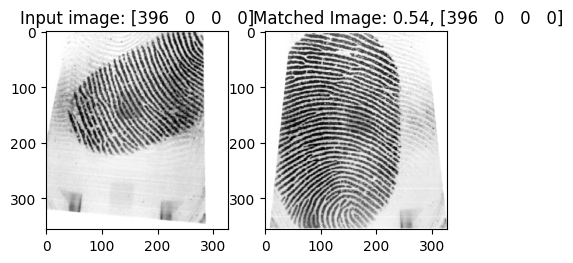

In [174]:

# new user fingerprint input (using test set)
# Ensure test set variables are defined (in case Cell 1 wasn't run)
if 'x_test' not in globals():
    x_test = None
    label_test = None
    test_file_paths = None

if x_test is None:
    print("Warning: Test set not loaded, using validation set instead")
    random_idx = random.randint(1, len(x_val))
    random_img = x_val[random_idx]
    random_label = label_val[random_idx]
    input_file_paths = val_file_paths
    data_source = "validation set"
else:
    random_idx = random.randint(1, len(x_test))
    random_img = x_test[random_idx]
    random_label = label_test[random_idx]
    input_file_paths = test_file_paths
    data_source = "test set"

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 356, 328, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# Get file paths for both images
# Image 1: Input image from test set (or validation set if test set not available)
input_image_path = input_file_paths[random_idx]

# Image 2: Matched reference image from x_real
x_real_idx = label_real_dict[match_key]
reference_image_path = x_real_file_paths[x_real_idx]

# Print file paths
print("="*60)
print("Image File Paths")
print("="*60)
print(f"Input Image (from {data_source}):")
print(f"  Index in {data_source}: {random_idx}")
print(f"  Label: {random_label}")
print(f"  File path: {input_image_path}")
print(f"  Absolute path: {os.path.abspath(input_image_path)}")
print(f"\nMatched Reference Image (from x_real):")
print(f"  Index in x_real: {x_real_idx}")
print(f"  Label: {ry}")
print(f"  Match key: {match_key}")
print(f"  File path: {reference_image_path}")
print(f"  Absolute path: {os.path.abspath(reference_image_path)}")
print(f"\nPrediction score: {pred_rx[0][0]:.4f}")
print("="*60)

# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image File Paths
Input Image (from test set):
  Index in test set: 34
  Label: [34  0  0  0]
  File path: Project-Data/test/034_R0_4.bmp
  Absolute path: /Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/Project-Data/test/034_R0_4.bmp

Matched Reference Image (from x_real):
  Index in x_real: 34
  Label: [34  0  0  0]
  Match key: 034000
  File path: Project-Data/train/034_R0_0.bmp
  Absolute path: /Users/sohpie/Documents/GitHub/CSC_591_fingerprint_authentication_Siamese/Project-Data/train/034_R0_0.bmp

Prediction score: 0.5356


/var/folders/7d/n5_y1thj0vgfvx7qbmy8lln80000gn/T/ipykernel_98032/1786467461.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))


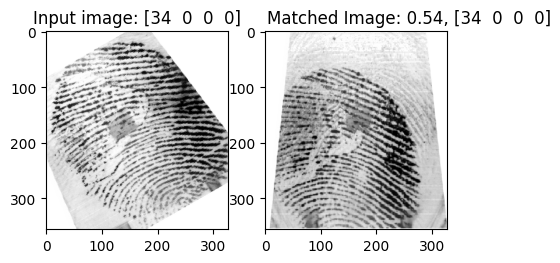

In [175]:
# new user fingerprint input (using test set)
# Ensure test set variables are defined (in case Cell 1 wasn't run)

random_idx = random.randint(1, len(x_test))
random_img = x_test[random_idx]
random_label = label_test[random_idx]
input_file_paths = test_file_paths
data_source = "test set"

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 356, 328, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# Get file paths for both images
# Image 1: Input image from test set (or validation set if test set not available)
input_image_path = input_file_paths[random_idx]

# Image 2: Matched reference image from x_real
x_real_idx = label_real_dict[match_key]
reference_image_path = x_real_file_paths[x_real_idx]

# Print file paths
print("="*60)
print("Image File Paths")
print("="*60)
print(f"Input Image (from {data_source}):")
print(f"  Index in {data_source}: {random_idx}")
print(f"  Label: {random_label}")
print(f"  File path: {input_image_path}")
print(f"  Absolute path: {os.path.abspath(input_image_path)}")
print(f"\nMatched Reference Image (from x_real):")
print(f"  Index in x_real: {x_real_idx}")
print(f"  Label: {ry}")
print(f"  Match key: {match_key}")
print(f"  File path: {reference_image_path}")
print(f"  Absolute path: {os.path.abspath(reference_image_path)}")
print(f"\nPrediction score: {pred_rx[0][0]:.4f}")
print("="*60)

# unmatched image
# unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

# ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
# uy = y_real[unmatch_idx]

# pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input image: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('                    Matched Image: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
# plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
# plt.imshow(ux.squeeze(), cmap='gray')

In [176]:
# ============================================
# Calculate Evaluation Metrics: IMR, FMR, FNMR, EER, etc.
# ============================================
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import time

def calculate_fingerprint_metrics(model, x_val, label_val, x_real, label_real_dict, 
                                   num_samples=500, batch_size=32):
    """
    Calculate evaluation metrics for fingerprint recognition system
    
    Parameters:
        model: Trained model
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference image set
        label_real_dict: Dictionary mapping labels to reference images
        num_samples: Number of samples for evaluation
        batch_size: Batch size
    
    Returns:
        metrics: Dictionary containing various metrics
    """
    print("Starting to calculate evaluation metrics...")
    print(f"Using {num_samples} samples for evaluation")
    
    # Limit number of samples to speed up calculation
    num_samples = min(num_samples, len(x_val))
    indices = np.random.choice(len(x_val), num_samples, replace=False)
    x_test = x_val[indices]
    label_test = label_val[indices]
    
    # Store matching scores and true labels
    genuine_scores = []  # Genuine match scores
    impostor_scores = []  # Impostor match scores
    
    print("Calculating matching scores...")
    start_time = time.time()
    
    # Calculate genuine match scores (same fingerprint)
    for i in range(num_samples):
        img1 = x_test[i].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
        label1 = label_test[i]
        
        # Find corresponding reference image
        match_key = label1.astype(str)
        match_key = ''.join(match_key).zfill(6)
        
        if match_key in label_real_dict:
            img2 = x_real[label_real_dict[match_key]].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
            score = model.predict([img1, img2], verbose=0)[0][0]
            genuine_scores.append(score)
        
        if (i + 1) % 50 == 0:
            print(f"  Processing progress: {i+1}/{num_samples}")
    
    # Calculate impostor match scores (different fingerprints)
    print("Calculating impostor match scores...")
    num_impostor = min(num_samples, len(label_real_dict) * 10)  # Limit number of impostor matches
    
    for i in range(num_impostor):
        # Randomly select a test image
        idx1 = np.random.randint(0, num_samples)
        img1 = x_test[idx1].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
        label1 = label_test[idx1]
        
        # Randomly select a different reference image
        while True:
            unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
            label1_key = label1.astype(str)
            label1_key = ''.join(label1_key).zfill(6)
            if unmatch_key != label1_key:
                break
        
        img2 = x_real[unmatch_idx].reshape((1, 356, 328, 1)).astype(np.float32) / 255.
        score = model.predict([img1, img2], verbose=0)[0][0]
        impostor_scores.append(score)
        
        if (i + 1) % 50 == 0:
            print(f"  Processing progress: {i+1}/{num_impostor}")
    
    elapsed_time = time.time() - start_time
    print(f"\nCalculation complete, elapsed time: {elapsed_time:.2f} seconds")
    
    genuine_scores = np.array(genuine_scores)
    impostor_scores = np.array(impostor_scores)
    
    print(f"\nGenuine match score statistics:")
    print(f"  Count: {len(genuine_scores)}")
    print(f"  Mean: {genuine_scores.mean():.4f}")
    print(f"  Std: {genuine_scores.std():.4f}")
    print(f"  Min: {genuine_scores.min():.4f}")
    print(f"  Max: {genuine_scores.max():.4f}")
    
    print(f"\nImpostor match score statistics:")
    print(f"  Count: {len(impostor_scores)}")
    print(f"  Mean: {impostor_scores.mean():.4f}")
    print(f"  Std: {impostor_scores.std():.4f}")
    print(f"  Min: {impostor_scores.min():.4f}")
    print(f"  Max: {impostor_scores.max():.4f}")
    
    # Calculate metrics at different thresholds
    thresholds = np.arange(0.0, 1.01, 0.01)
    fmr_list = []  # False Match Rate
    fnmr_list = []  # False Non-Match Rate
    
    for threshold in thresholds:
        # FMR: Proportion of impostor matches incorrectly accepted
        fmr = np.sum(impostor_scores >= threshold) / len(impostor_scores)
        fmr_list.append(fmr)
        
        # FNMR: Proportion of genuine matches incorrectly rejected
        fnmr = np.sum(genuine_scores < threshold) / len(genuine_scores)
        fnmr_list.append(fnmr)
    
    fmr_list = np.array(fmr_list)
    fnmr_list = np.array(fnmr_list)
    
    # Calculate EER (Equal Error Rate)
    # EER is the error rate when FMR and FNMR are equal
    diff = np.abs(fmr_list - fnmr_list)
    eer_idx = np.argmin(diff)
    eer_threshold = thresholds[eer_idx]
    eer = (fmr_list[eer_idx] + fnmr_list[eer_idx]) / 2
    
    # Calculate IMR (Identification Match Rate)
    # Use EER threshold as decision threshold
    correct_matches = np.sum(genuine_scores >= eer_threshold)
    imr = correct_matches / len(genuine_scores)
    
    # Calculate ROC curve and AUC
    all_scores = np.concatenate([genuine_scores, impostor_scores])
    all_labels = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    
    # Calculate accuracy, precision, recall using EER threshold
    predictions = (all_scores >= eer_threshold).astype(int)
    accuracy = accuracy_score(all_labels, predictions)
    precision = precision_score(all_labels, predictions)
    recall = recall_score(all_labels, predictions)
    f1 = f1_score(all_labels, predictions)
    
    metrics = {
        'genuine_scores': genuine_scores,
        'impostor_scores': impostor_scores,
        'thresholds': thresholds,
        'fmr_list': fmr_list,
        'fnmr_list': fnmr_list,
        'eer': eer,
        'eer_threshold': eer_threshold,
        'imr': imr,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return metrics

# Calculate evaluation metrics
metrics = calculate_fingerprint_metrics(
    model, x_val, label_val, x_real, label_real_dict, 
    num_samples=min(500, len(x_val)), batch_size=32
)

# Print main metrics
print("\n" + "="*60)
print("Evaluation Metrics Results")
print("="*60)
print(f"IMR (Identification Match Rate): {metrics['imr']:.4f} ({metrics['imr']*100:.2f}%)")
print(f"EER (Equal Error Rate): {metrics['eer']:.4f} ({metrics['eer']*100:.2f}%)")
print(f"EER Threshold: {metrics['eer_threshold']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"Precision: {metrics['precision']:.4f} ({metrics['precision']*100:.2f}%)")
print(f"Recall: {metrics['recall']:.4f} ({metrics['recall']*100:.2f}%)")
print(f"F1 Score: {metrics['f1']:.4f}")
print("="*60)


Starting to calculate evaluation metrics...
Using 500 samples for evaluation
Calculating matching scores...
  Processing progress: 50/500
  Processing progress: 100/500
  Processing progress: 150/500
  Processing progress: 200/500
  Processing progress: 250/500
  Processing progress: 300/500
  Processing progress: 350/500
  Processing progress: 400/500
  Processing progress: 450/500
  Processing progress: 500/500
Calculating impostor match scores...
  Processing progress: 50/500
  Processing progress: 100/500
  Processing progress: 150/500
  Processing progress: 200/500
  Processing progress: 250/500
  Processing progress: 300/500
  Processing progress: 350/500
  Processing progress: 400/500
  Processing progress: 450/500
  Processing progress: 500/500

Calculation complete, elapsed time: 28.65 seconds

Genuine match score statistics:
  Count: 488
  Mean: 0.5784
  Std: 0.2783
  Min: 0.0021
  Max: 0.9991

Impostor match score statistics:
  Count: 500
  Mean: 0.2164
  Std: 0.2634
  Min: 

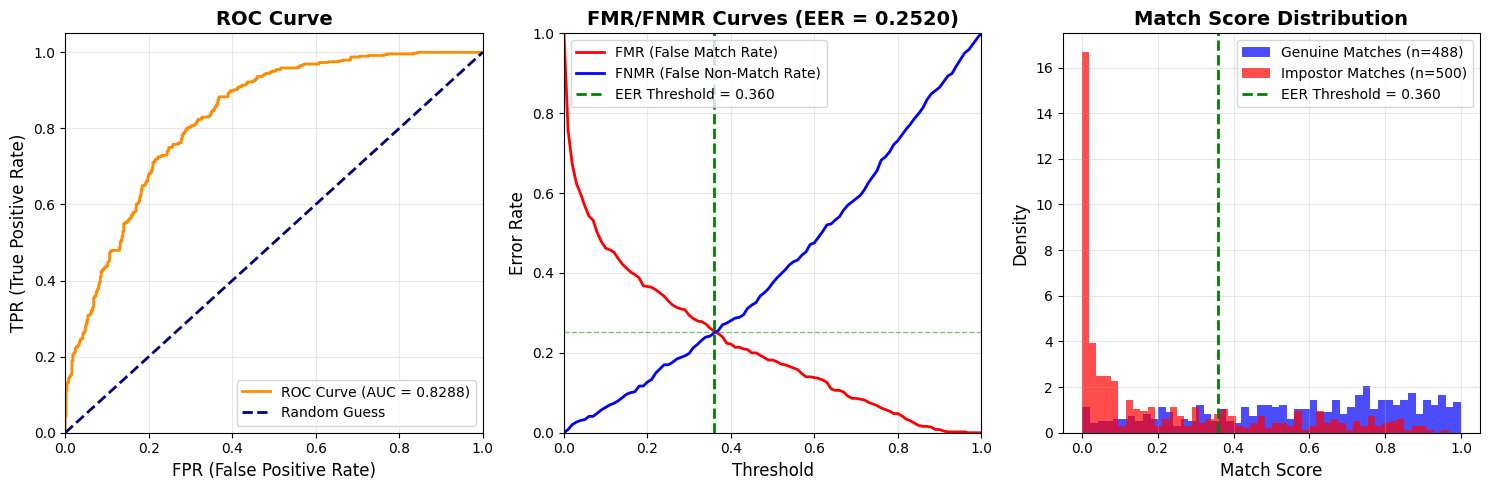


Detailed Statistics

Performance at EER threshold (0.3600):
  FMR (False Match Rate): 0.2540 (25.40%)
  FNMR (False Non-Match Rate): 0.2500 (25.00%)
  IMR (Identification Match Rate): 0.7500 (75.00%)


In [177]:
# ============================================
# Visualize Evaluation Metrics: ROC Curve, FMR/FNMR Curves, Score Distribution
# ============================================

# 1. Plot ROC curve
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics['fpr'], metrics['tpr'], color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (False Positive Rate)', fontsize=12)
plt.ylabel('TPR (True Positive Rate)', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# 2. Plot FMR/FNMR curves
plt.subplot(1, 3, 2)
plt.plot(metrics['thresholds'], metrics['fmr_list'], 'r-', lw=2, label='FMR (False Match Rate)')
plt.plot(metrics['thresholds'], metrics['fnmr_list'], 'b-', lw=2, label='FNMR (False Non-Match Rate)')
plt.axvline(x=metrics['eer_threshold'], color='green', linestyle='--', lw=2, 
            label=f'EER Threshold = {metrics["eer_threshold"]:.3f}')
plt.axhline(y=metrics['eer'], color='green', linestyle='--', lw=1, alpha=0.5)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title(f'FMR/FNMR Curves (EER = {metrics["eer"]:.4f})', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# 3. Plot score distribution histogram
plt.subplot(1, 3, 3)
plt.hist(metrics['genuine_scores'], bins=50, alpha=0.7, color='blue', 
         label=f'Genuine Matches (n={len(metrics["genuine_scores"])})', density=True)
plt.hist(metrics['impostor_scores'], bins=50, alpha=0.7, color='red', 
         label=f'Impostor Matches (n={len(metrics["impostor_scores"])})', density=True)
plt.axvline(x=metrics['eer_threshold'], color='green', linestyle='--', lw=2, 
            label=f'EER Threshold = {metrics["eer_threshold"]:.3f}')
plt.xlabel('Match Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Match Score Distribution', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("Detailed Statistics")
print("="*60)
print(f"\nPerformance at EER threshold ({metrics['eer_threshold']:.4f}):")
print(f"  FMR (False Match Rate): {metrics['fmr_list'][int(metrics['eer_threshold']*100)]:.4f} ({metrics['fmr_list'][int(metrics['eer_threshold']*100)]*100:.2f}%)")
print(f"  FNMR (False Non-Match Rate): {metrics['fnmr_list'][int(metrics['eer_threshold']*100)]:.4f} ({metrics['fnmr_list'][int(metrics['eer_threshold']*100)]*100:.2f}%)")
print(f"  IMR (Identification Match Rate): {metrics['imr']:.4f} ({metrics['imr']*100:.2f}%)")
print("="*60)
